<ipython-input-14-1963054328>:104: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1963054328>:104: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-inpu

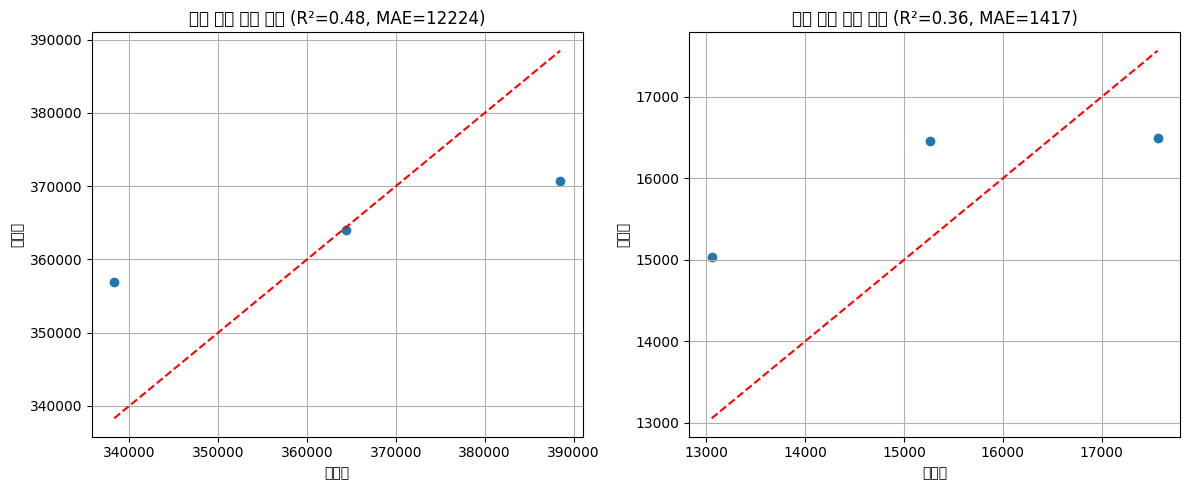

입력변수 중요도(가중 소형 차량 예측 기준):
월         0.477642
연도        0.248423
공연_건수     0.113828
축제_건수     0.107094
이벤트_건수    0.053013
dtype: float64


In [14]:
# 1. Colab 한글 폰트 설정
!pip install koreanize-matplotlib

# 2. 패키지 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import koreanize_matplotlib

# 3. 데이터 불러오기
festival_file = "새만금개발청_새만금지역 축제현황_20230830.csv"
event_file = "새만금개발청_새만금지역 공연행사_20230830.csv"
traffic_file = "새만금개발청_새만금 방조제 교통량_20230831.csv"

festival_df = pd.read_csv(festival_file, encoding="euc-kr")
event_df = pd.read_csv(event_file, encoding="euc-kr")
traffic_df = pd.read_csv(traffic_file, encoding="euc-kr")

# 4. 날짜에서 연도, 월 추출
def extract_year_month(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['연도'] = df[date_col].dt.year
    df['월'] = df[date_col].dt.month
    return df

festival_df = extract_year_month(festival_df, '축제시작일')
event_df = extract_year_month(event_df, '행사시작일')

# 5. 월별 축제, 공연 건수 집계
festival_month = festival_df.groupby(['연도', '월']).size().reset_index(name='축제_건수')
event_month = event_df.groupby(['연도', '월']).size().reset_index(name='공연_건수')

# 6. 월별 전체 이벤트 건수 계산
total_event = pd.merge(festival_month, event_month, on=['연도', '월'], how='outer').fillna(0)
total_event['이벤트_건수'] = total_event['축제_건수'] + total_event['공연_건수']

# 7. 교통량 데이터 전처리 + 군산↔부안 가중치
traffic_df.rename(columns={'조사일 년': '연도', '조사월': '월'}, inplace=True)
traffic_df['연도'] = pd.to_numeric(traffic_df['연도'], errors='coerce')
traffic_df['월'] = pd.to_numeric(traffic_df['월'], errors='coerce')

def apply_weight(row):
    if (row['출발'] == '군산' and row['도착지'] == '부안') or (row['출발'] == '부안' and row['도착지'] == '군산'):
        return 2
    else:
        return 1
traffic_df['가중치'] = traffic_df.apply(apply_weight, axis=1)
traffic_df['가중 소형 차량'] = traffic_df['소형 차량'] * traffic_df['가중치']
traffic_df['가중 대형 차량'] = traffic_df['대형 차량'] * traffic_df['가중치']

# 8. 월별 (가중치 적용) 교통량 집계
traffic_month = traffic_df.groupby(['연도', '월']).agg({
    '가중 소형 차량': 'sum',
    '가중 대형 차량': 'sum'
}).reset_index()

# 9. 모든 집계 데이터 병합 (입력변수+타깃)
df = pd.merge(total_event, traffic_month, on=['연도', '월'], how='inner')

# 10. 입력변수(X), 타깃(y) 지정
X = df[['연도', '월', '축제_건수', '공연_건수', '이벤트_건수']]
y_small = df['가중 소형 차량']
y_big = df['가중 대형 차량']

# 11. 데이터 분리(학습/테스트)
X_train, X_test, y_small_train, y_small_test = train_test_split(
    X, y_small, test_size=0.3, random_state=42
)
X_train2, X_test2, y_big_train, y_big_test = train_test_split(
    X, y_big, test_size=0.3, random_state=42
)

# 12. 랜덤포레스트 회귀로 예측 (각각)
model_small = RandomForestRegressor(random_state=42, n_estimators=200)
model_small.fit(X_train, y_small_train)
small_pred = model_small.predict(X_test)

model_big = RandomForestRegressor(random_state=42, n_estimators=200)
model_big.fit(X_train2, y_big_train)
big_pred = model_big.predict(X_test2)

# 13. 평가 및 시각화
def plot_result(y_test, y_pred, title):
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_result(y_small_test, small_pred,
            f'가중 소형 차량 예측 (R²={r2_score(y_small_test, small_pred):.2f}, MAE={mean_absolute_error(y_small_test, small_pred):.0f})')

plt.subplot(1, 2, 2)
plot_result(y_big_test, big_pred,
            f'가중 대형 차량 예측 (R²={r2_score(y_big_test, big_pred):.2f}, MAE={mean_absolute_error(y_big_test, big_pred):.0f})')

plt.tight_layout()
plt.show()

# 14. 중요도(Feature importance) 확인
importances = pd.Series(model_small.feature_importances_, index=X.columns)
print("입력변수 중요도(가중 소형 차량 예측 기준):")
print(importances.sort_values(ascending=False))
